In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [2]:
test = pd.read_csv('./data/test.csv')
print(test.shape)
test.head()

(367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


# Examining the Data

In [3]:
# Unique text values per column
obj_cols = list(train.columns[train.dtypes=='object'])
obj_cols.remove('Loan_ID')
obj_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [4]:
for col in obj_cols:
    print(f"{col}:")
    print(f"{train[col].unique()}\n")

Gender:
['Male' 'Female' nan]

Married:
['No' 'Yes' nan]

Dependents:
['0' '1' '2' '3+' nan]

Education:
['Graduate' 'Not Graduate']

Self_Employed:
['No' 'Yes' nan]

Property_Area:
['Urban' 'Rural' 'Semiurban']

Loan_Status:
['Y' 'N']



First, the ```Loan_Status``` column would be much more useful to utilize in plots if encoded into integer forms. In this notebook, I will encode 'Y' as a, and 'N' as 0

In [5]:
train.loc[train.Loan_Status=='Y','Status_encoded'] = 1
train.loc[train.Loan_Status=='N','Status_encoded'] = 0
print(train.shape)
train.head()

(614, 14)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Status_encoded
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,1.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,1.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,1.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,1.0


**Columns**
* Gender
* Marriage Status
* Dependents
* Education
* Employment Type
* Applicant Income
* Coapplicant Income
* Loan Amount
* Loan Amount Term
* Credit History

In [6]:
train.Gender.value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

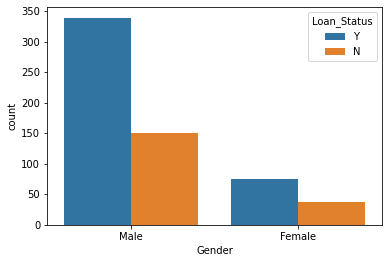

In [8]:
# Does gender affect loan status?
sns.countplot(data=train, x='Gender', hue='Loan_Status')

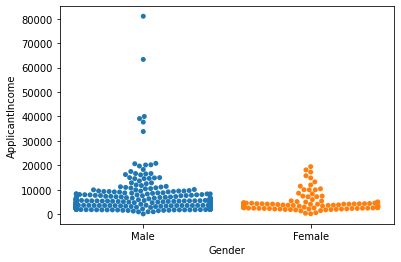

In [13]:
sns.swarmplot(data=train, x='Gender', y='ApplicantIncome')

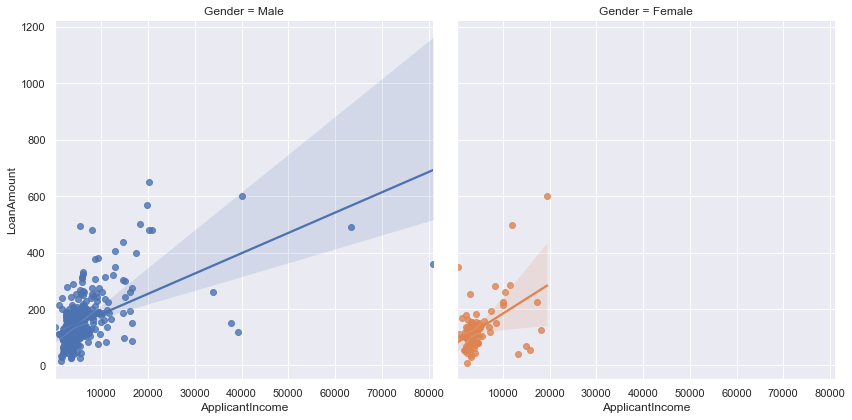

In [32]:
sns.lmplot(data=train, x='ApplicantIncome', y='LoanAmount', hue='Gender', col='Gender', height=6)

In [53]:
# Excluding the outliers
super_rich = train[train.ApplicantIncome>10000]
rich = train[train.ApplicantIncome>6000]

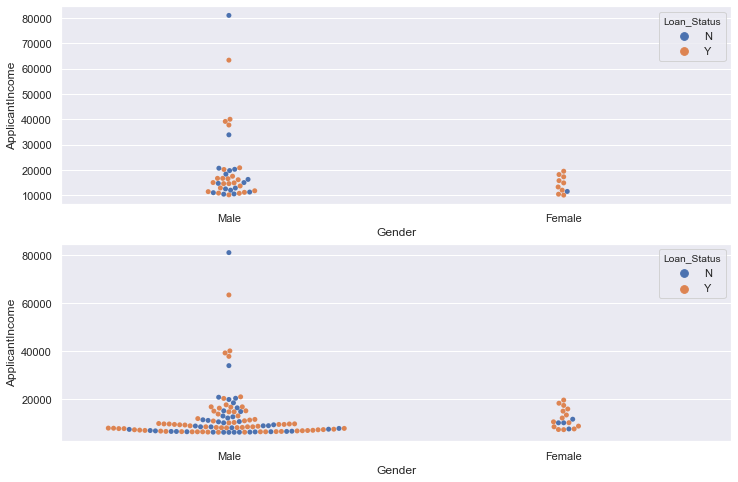

In [54]:
from pylab import *

sns.set(rc={'figure.figsize':(12,8)})

subplot(2,1,1)
f1 = sns.swarmplot(data=super_rich, x='Gender', y='ApplicantIncome', hue='Loan_Status')

subplot(2,1,2)
f2 = sns.swarmplot(data=rich, x='Gender', y='ApplicantIncome', hue='Loan_Status')

plt.show()

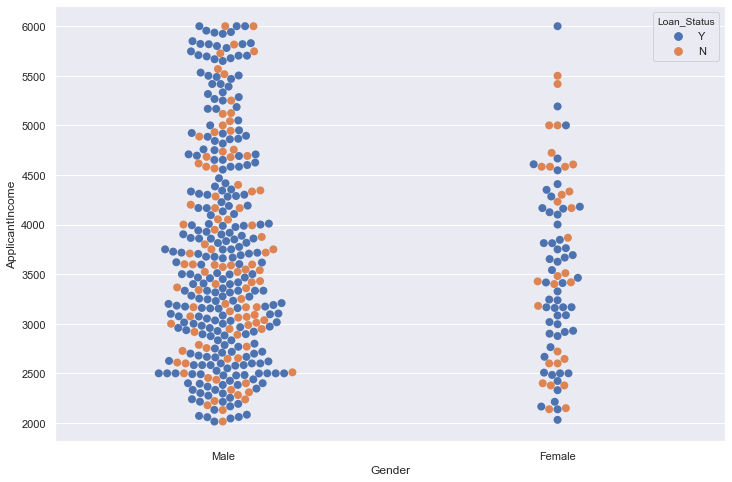

In [73]:
middle_income = train[(train.ApplicantIncome<=6000) & (train.ApplicantIncome>2000)]
sns.swarmplot(data=middle_income, x='Gender', y='ApplicantIncome', hue='Loan_Status', size=8)

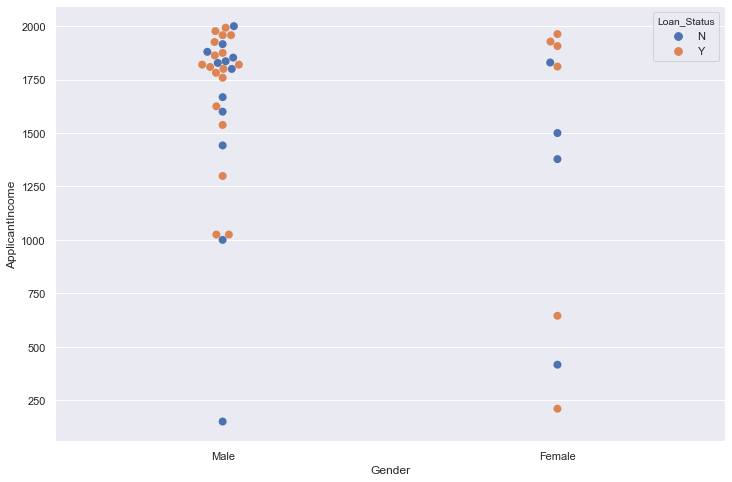

In [68]:
low_income = train[train.ApplicantIncome<=2000]
sns.swarmplot(data=poor, x='Gender', y='ApplicantIncome', hue='Loan_Status', size=8)

In [ ]:
train.loc[train.Gender=='Male','Gender_encoded'] = 0
train.loc[train.Gender=='Female','Gender_encoded'] = 1
print(train.shape)
train.head()

In [ ]:
corr = train.corr()
corr

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='YlGnBu')

In [75]:
t = train.copy()
t

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Status_encoded
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,1.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,1.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,1.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,1.0
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,1.0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,1.0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,1.0
